In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.color import label2rgb

In [2]:
def set_color(segmentation_image):
    rgb_image = np.zeros((28, 28, 3), np.uint8)
    for x, ps in enumerate(segmentation_image):
        for y, p in enumerate(ps):
            p = p - 1
            if p == 0:
                rgb_image[x, y, :] = [127, 127, 127]
            if p == 1:
                rgb_image[x, y, :] = [255,   0,   0]
            if p == 2:
                rgb_image[x, y, :] = [  0, 255,   0]
            if p == 3:
                rgb_image[x, y, :] = [  0,   0, 255]
            if p == 4:
                rgb_image[x, y, :] = [255, 255,   0]
            if p == 5:
                rgb_image[x, y, :] = [  0, 255, 255]
            if p == 6:
                rgb_image[x, y, :] = [255,   0, 255]
            if p == 7:
                rgb_image[x, y, :] = [127, 127,   0]
            if p == 8:
                rgb_image[x, y, :] = [  0, 127, 127]
            if p == 9:
                rgb_image[x, y, :] = [127,   0, 127]
    return rgb_image

In [3]:
class SegmentationMNIST(Dataset):
    def __init__(self, root, train, threshold):
        super().__init__()
        self.mnist = MNIST(root = root, train = train)
        self.threshold = threshold
        
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, index):
        np_image = np.zeros((1, 28, 28), np.uint8)
        np_mask  = np.zeros((1, 28, 28), np.uint8)
        np_image[0, :, :], label = self.mnist[index]
        np_mask[0, :, :]  = np.where(np_image > self.threshold, label + 1, 0) # 背景クラスを0に設定
        torch_image = torch.from_numpy(np_image / 255).to(torch.float32)
        torch_mask  = torch.from_numpy(np_mask).to(torch.long)
        return torch_image, torch_mask

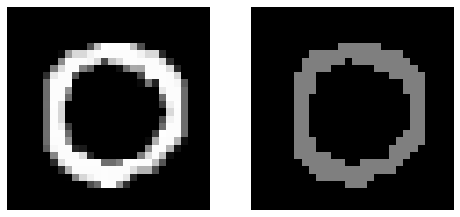

In [4]:
train_data = SegmentationMNIST(root = "../../data", train = True,  threshold = 127)
test_data  = SegmentationMNIST(root = "../../data", train = False, threshold = 127)
train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_dataloader  = DataLoader(test_data,  batch_size = 64, shuffle = True)
# 辞書型変数にまとめると学習・検証の実施時に扱いやすくなる
dataloaders_dict = {"train" : train_dataloader, "test" : test_dataloader}
# イテレータに変換
batch_iterator = iter(dataloaders_dict["test"])
# 要素を取り出す
imgs, masks = next(batch_iterator)
# 画像表示
figure = plt.figure(figsize = (8, 8))
rows, cols = 2, 1
# 画像
figure.add_subplot(cols, rows, 1)
plt.axis("off")
plt.imshow(imgs[0].squeeze().numpy(), cmap = "gray")
# マスク画像
figure.add_subplot(cols, rows, 2)
plt.axis("off")
plt.imshow(set_color(masks[0].squeeze().numpy()), cmap = "gray")
plt.show()

In [5]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.loss_train_log = []
        self.loss_test_log = []
        self.acc_train_log = []
        self.acc_test_log = []
        
        # エンコーダー部
        self.encoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, 64, 3, stride = 1, padding = 1), # [N, 64, 28, 28]
                nn.ReLU(inplace = True),

                nn.Conv2d(64, 64, 3, stride = 1, padding = 1, bias = False), # [N, 64, 28, 28]
                nn.BatchNorm2d(64),
                nn.ReLU(inplace = True)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),
                
                nn.Conv2d(64, 128, 3, stride = 1, padding = 1, bias = False), # [N, 128, 14, 14]
                nn.BatchNorm2d(128),
                nn.ReLU(inplace = True),
                
                nn.Conv2d(128, 128, 3, stride = 1, padding = 1, bias = False), # [N, 128, 14, 14]
                nn.BatchNorm2d(128),
                nn.ReLU(inplace = True)
            )
        ])
        
        # ボトルネック部
        self.bottle_neck = nn.Sequential(
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3, stride = 1, padding = 1, bias = False), # [N, 256, 7, 7]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(256, 256, 3, stride = 1, padding = 1, bias = False), # [N, 256, 7, 7]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            
            nn.Upsample(scale_factor = 2, mode = "bilinear", align_corners = False) # [N, 256, 14, 14]
        )
        
        # デコーダー部
        self.decoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(128 + 256, 128, 3, stride = 1, padding = 1, bias = False), # [N, 128, 14, 14]
                nn.BatchNorm2d(128),
                nn.ReLU(inplace = True),
                
                nn.Conv2d(128, 128, 3, stride = 1, padding = 1, bias = False), # [N, 128, 14, 14]
                nn.BatchNorm2d(128),
                nn.ReLU(inplace = True),
                
                nn.Upsample(scale_factor = 2, mode = "bilinear", align_corners = False) # [N, 128, 28, 28]
            ),
            nn.Sequential(
                nn.Conv2d(64 + 128, 64, 3, stride = 1, padding = 1, bias = False), # [N, 64, 28, 28]
                nn.BatchNorm2d(64),
                nn.ReLU(inplace = True),
                
                nn.Conv2d(64, 64, 3, stride = 1, padding = 1, bias = False), # [N, 64, 28, 28]
                nn.BatchNorm2d(64),
                nn.ReLU(inplace = True),
                
                nn.Conv2d(64, num_classes, 1, stride = 1, padding = 0) # [N, 11, 28, 28]
            )
        ])
        
        # 誤差関数の設定
        self.loss = nn.MSELoss() 
        # 最適化手法の設定
        self.optimizer = optim.Adam(self.parameters(), lr = 1e-2)
    
    def forward(self, x):
        h_list = [] # 特徴マップを格納するリスト
        for block in self.encoder:
            x = block(x)
            h_list.append(x)
        
        x = self.bottle_neck(x)
        
        for h, block in zip(h_list[::-1], self.decoder):
            x = block(torch.cat([h, x], dim = 1))
        
        return x
    
model = torch.load("../../model/SemanticSegmentation-mnist.pth")

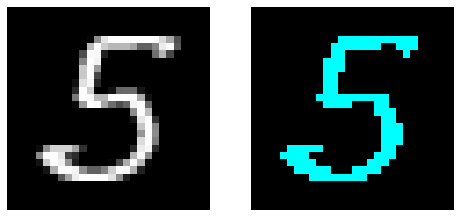

In [6]:
idx = torch.randint(low = 0, high = len(imgs), size = (1, 1)).item()
img, mask = imgs[idx], masks[idx]
# 画像表示
figure = plt.figure(figsize = (8, 8))
rows, cols = 2, 1
# 画像
figure.add_subplot(cols, rows, 1)
plt.axis("off")
plt.imshow(imgs[idx].squeeze().numpy(), cmap = "gray")
# マスク画像
figure.add_subplot(cols, rows, 2)
plt.axis("off")
pred = model(imgs)
plt.imshow(set_color(pred[idx].detach().numpy().argmax(axis = 0)), cmap = "gray")
plt.show()

In [7]:
def batch_predict(np_rgb_imgs):
    np_imgs = np.zeros((len(np_rgb_imgs), 1, 28, 28))
    for i, np_rgb_img in enumerate(np_rgb_imgs):
        np_imgs[i, 0, :, :] = (np_rgb_img[:, :, 0] + np_rgb_img[:, :, 1] + np_rgb_img[:, :, 2]) / 3
    y = model(torch.from_numpy(np_imgs).to(torch.float32))
    return y.detach().numpy()[:, :, 14, 14]

In [8]:
#imgs, labels = next(iter(dataloaders_dict["test"]))
explainer = lime_image.LimeImageExplainer()
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
explanation = explainer.explain_instance(image = imgs[idx].squeeze().numpy(),
                                         classifier_fn = batch_predict,
                                         top_labels=11,
                                         hide_color=0,
                                         num_samples=10000,
                                         segmentation_fn=segmenter
)

  0%|          | 0/10000 [00:00<?, ?it/s]

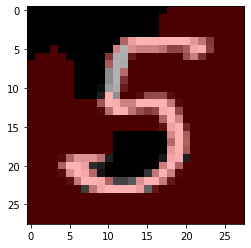

In [9]:
temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=4, hide_rest=False)
fig, (ax1) = plt.subplots(1, 1, figsize = (8, 4))
ax1.imshow(label2rgb(mask, temp, bg_label = 0), interpolation = 'nearest')
plt.show()

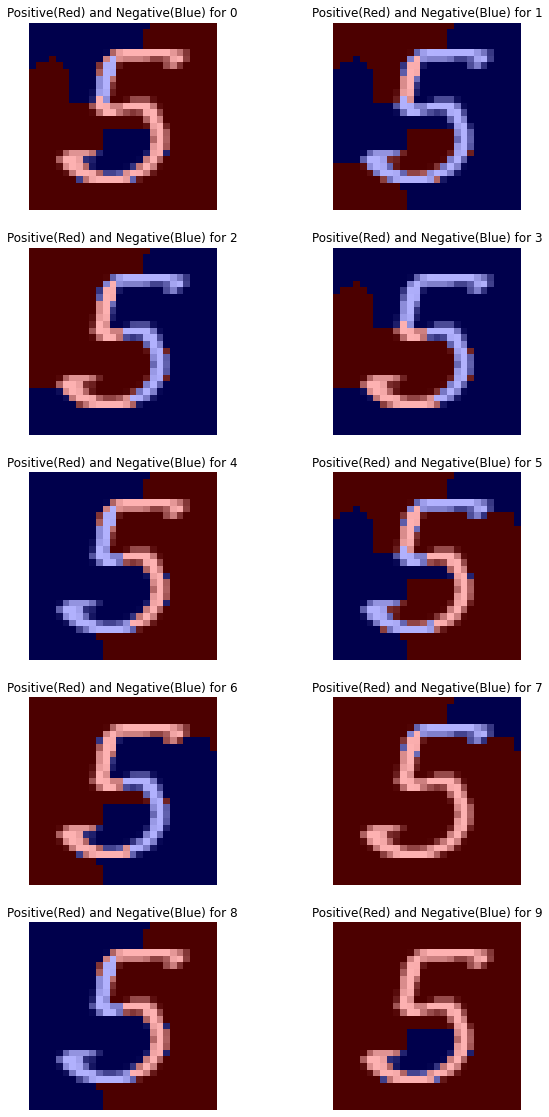

In [10]:
fig, m_axs = plt.subplots(5,2, figsize = (10, 20))
#print(f"Ans : {labels[0]}, Output : {model(imgs[0]).argmax(axis=1).item()}")
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=False, num_features=10, hide_rest=False)
    c_ax.imshow(label2rgb(3-mask, imgs[idx].squeeze().numpy(), bg_label = 0), interpolation = 'nearest')
    c_ax.set_title(f'Positive(Red) and Negative(Blue) for {i}')
    c_ax.axis('off')